# Data Analysis

#### Imports

In [1]:
%matplotlib inline

import pandas as pd
pd.options.display.max_rows = 999
import sqlite3
import statsmodels.formula.api as sm
# import statsmodels.api as s
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

# from sklearn.linear_model import LogisticRegression
# from sklearn.cross_validation import cross_val_score

#### Database Connection

In [2]:
conn = sqlite3.connect("./sample.db")

#### Occupy Dataframe

In [3]:
# df_occupy = pd.read_sql(sql="SELECT * FROM occupy", con=conn)
df_occupy_1 = pd.read_sql(sql="SELECT room, date, time, associated_client_count, authenticated_client_count FROM occupy", con=conn)
df_occupy_2 = pd.read_sql(sql="SELECT room, date, time, module_code, occupancy FROM occupy", con=conn)

#### Only consider rows with the following conditions satisfied:

* **Condition 1**: time between 9:00 and 17:00
* **Condition 2:** This condition is because we want to take the average authenticated client count between these times. We are disregarding the other figures because we are not sure of the DHCP lease duration. For instance, a number of the devices could still be being considered from an individual who has already left the room but the lease is still considered.
    - time >= quarter past the hour
    - time <= quarter past the hour

In [4]:
df_occupy_1["condition1"] = df_occupy_1["time"].apply(lambda x: "true" if 17 >= int(x[0:2]) >= 9 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition1"] == "true"]
df_occupy_1

,room,date,time,associated_client_count,authenticated_client_count,condition1
0,B-002,20151102,09:00,NaN,NaN,true
1,B-002,20151102,10:00,NaN,NaN,true
2,B-002,20151102,11:00,NaN,NaN,true
3,B-002,20151102,12:00,NaN,NaN,true
4,B-002,20151102,13:00,NaN,NaN,true
5,B-002,20151102,14:00,NaN,NaN,true
6,B-002,20151102,15:00,NaN,NaN,true
7,B-002,20151102,16:00,NaN,NaN,true
8,B-002,20151102,17:00,NaN,NaN,true
9,B-002,20151109,09:00,NaN,NaN,true


In [5]:
df_occupy_1["condition2"] = df_occupy_1["time"].apply(lambda x: "true" if 45 >= int(x[-2:]) >= 15 else "false")
df_occupy_1 = df_occupy_1[df_occupy_1["condition2"] == "true"]
df_occupy_1

,room,date,time,associated_client_count,authenticated_client_count,condition1,condition2
426,B-002,20151103,09:16,0,0,true,true
427,B-002,20151103,09:21,1,1,true,true
428,B-002,20151103,09:27,2,2,true,true
429,B-002,20151103,09:32,1,1,true,true
430,B-002,20151103,09:37,4,4,true,true
431,B-002,20151103,09:42,4,4,true,true
438,B-002,20151103,10:18,30,30,true,true
439,B-002,20151103,10:23,30,30,true,true
440,B-002,20151103,10:28,31,31,true,true
441,B-002,20151103,10:33,29,29,true,true


In [6]:
del df_occupy_1["condition1"]
del df_occupy_1["condition2"]
df_occupy_1["time"] = df_occupy_1["time"].apply(lambda x: x[0:3] + "00")
df_occupy_1

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,room,date,time,associated_client_count,authenticated_client_count
426,B-002,20151103,09:00,0,0
427,B-002,20151103,09:00,1,1
428,B-002,20151103,09:00,2,2
429,B-002,20151103,09:00,1,1
430,B-002,20151103,09:00,4,4
431,B-002,20151103,09:00,4,4
438,B-002,20151103,10:00,30,30
439,B-002,20151103,10:00,30,30
440,B-002,20151103,10:00,31,31
441,B-002,20151103,10:00,29,29


In [7]:
df_occupy_2

,room,date,time,module_code,occupancy
0,B-002,20151102,09:00,COMP30190,0.25
1,B-002,20151102,10:00,COMP40660,0.50
2,B-002,20151102,11:00,None,0.25
3,B-002,20151102,12:00,COMP30250,0.25
4,B-002,20151102,13:00,COMP41690,0.50
5,B-002,20151102,14:00,COMP30260,0.25
6,B-002,20151102,15:00,None,0.00
7,B-002,20151102,16:00,COMP40660,0.75
8,B-002,20151102,17:00,COMP40660,0.75
9,B-002,20151109,09:00,COMP30190,0.25


In [8]:
df_occupy_merge = pd.merge(left = df_occupy_1, right = df_occupy_2, how="outer", on=["room", "date", "time"]) 
df_occupy_merge.head(10)

,room,date,time,associated_client_count,authenticated_client_count,module_code,occupancy
0,B-002,20151103,09:00,0,0,None,0.0
1,B-002,20151103,09:00,1,1,None,0.0
2,B-002,20151103,09:00,2,2,None,0.0
3,B-002,20151103,09:00,1,1,None,0.0
4,B-002,20151103,09:00,4,4,None,0.0
5,B-002,20151103,09:00,4,4,None,0.0
6,B-002,20151103,10:00,30,30,COMP30110,0.5
7,B-002,20151103,10:00,30,30,COMP30110,0.5
8,B-002,20151103,10:00,31,31,COMP30110,0.5
9,B-002,20151103,10:00,29,29,COMP30110,0.5


In [9]:
df_occupy_merge.tail(10)

,room,date,time,associated_client_count,authenticated_client_count,module_code,occupancy
14660,B-004,20151117,10:34,NaN,NaN,None,NaN
14661,B-004,20151117,10:40,NaN,NaN,None,NaN
14662,B-004,20151117,10:45,NaN,NaN,None,NaN
14663,B-004,20151117,10:50,NaN,NaN,None,NaN
14664,B-004,20151117,10:56,NaN,NaN,None,NaN
14665,B-004,20151117,11:01,NaN,NaN,None,NaN
14666,B-004,20151117,11:06,NaN,NaN,None,NaN
14667,B-004,20151117,11:13,NaN,NaN,None,NaN
14668,B-004,20151117,11:21,NaN,NaN,None,NaN
14669,B-004,20151117,11:26,NaN,NaN,None,NaN


In [10]:
df_occupy = df_occupy_merge.groupby(["room", "date", "time", "module_code"], as_index=False).mean()

In [11]:
# df_occupy["authenticated_client_count"] = df_occupy["authenticated_client_count"].round(0)
# df_occupy["associated_client_count"] = df_occupy["associated_client_count"].round(0)
print(df_occupy.shape)
df_occupy

(182, 7)


,room,date,time,module_code,associated_client_count,authenticated_client_count,occupancy
0,B-002,20151102,09:00,COMP30190,NaN,NaN,0.25
1,B-002,20151102,10:00,COMP40660,NaN,NaN,0.50
2,B-002,20151102,12:00,COMP30250,NaN,NaN,0.25
3,B-002,20151102,13:00,COMP41690,NaN,NaN,0.50
4,B-002,20151102,14:00,COMP30260,NaN,NaN,0.25
5,B-002,20151102,16:00,COMP40660,NaN,NaN,0.75
6,B-002,20151102,17:00,COMP40660,NaN,NaN,0.75
7,B-002,20151103,10:00,COMP30110,29.000000,29.000000,0.50
8,B-002,20151103,11:00,COMP30260,27.200000,27.200000,0.50
9,B-002,20151103,12:00,COMP40370,11.833333,11.833333,0.50


#### Remove rows with NaN values 

In [12]:
df_occupy = df_occupy.dropna() 
print(df_occupy.shape)
df_occupy

(161, 7)


,room,date,time,module_code,associated_client_count,authenticated_client_count,occupancy
7,B-002,20151103,10:00,COMP30110,29.000000,29.000000,0.50
8,B-002,20151103,11:00,COMP30260,27.200000,27.200000,0.50
9,B-002,20151103,12:00,COMP40370,11.833333,11.833333,0.50
10,B-002,20151103,14:00,COMP30240,48.000000,48.000000,0.75
11,B-002,20151103,15:00,COMP30240,35.800000,35.400000,0.25
12,B-002,20151103,16:00,COMP40370,38.714286,38.142857,0.25
13,B-002,20151103,17:00,COMP40370,31.833333,31.666667,0.25
14,B-002,20151104,09:00,COMP30190,14.000000,14.000000,0.25
15,B-002,20151104,10:00,COMP40660,14.166667,14.166667,0.25
16,B-002,20151104,11:00,COMP30250,8.000000,7.833333,0.25


#### Module Dataframe

In [13]:
df_module = pd.read_sql(sql="SELECT * FROM module", con=conn)
df_module.head(10)

,module_code,reg_students
0,COMP10110,113
1,COMP10130,112
2,COMP10280,56
3,COMP20010,108
4,COMP20020,98
5,COMP20020_P1,53
6,COMP20020_P2,45
7,COMP20070,107
8,COMP20110,103
9,COMP20130,74


In [14]:
df_module.tail(10)

,module_code,reg_students
30,COMP41450 & COMP30120,143
31,COMP41690,60
32,COMP47290,0
33,COMP47300,0
34,ENVB30110,83
35,IS40640,49
36,MATH10130,56
37,MATH10200,96
38,SCI30060,66
39,STAT40150,0


#### Location Dataframe

In [15]:
df_location = pd.read_sql(sql="SELECT * FROM location", con=conn)
df_location.head(10)

,campus,building,room,capacity
0,Belfield,Computer Science,B-002,90
1,Belfield,Computer Science,B-003,90
2,Belfield,Computer Science,B-004,160


In [16]:
df_location.tail(10)

,campus,building,room,capacity
0,Belfield,Computer Science,B-002,90
1,Belfield,Computer Science,B-003,90
2,Belfield,Computer Science,B-004,160


#### Close db connection

In [17]:
conn.close()

## Construct Analytics Base Table

#### Join tables

In [18]:
df_abt = pd.merge(left = df_occupy, right = df_module, how="outer", on=["module_code"]) 
df_abt = pd.merge(left = df_abt, right = df_location, how="outer", on=["room"]) 
print(df_abt.shape)
df_abt

(162, 11)


,room,date,time,module_code,associated_client_count,authenticated_client_count,occupancy,reg_students,campus,building,capacity
0,B-002,20151103,10:00,COMP30110,29.000000,29.000000,0.50,45,Belfield,Computer Science,90
1,B-002,20151105,10:00,COMP30110,33.166667,33.166667,0.50,45,Belfield,Computer Science,90
2,B-002,20151110,10:00,COMP30110,24.666667,24.666667,0.00,45,Belfield,Computer Science,90
3,B-002,20151112,10:00,COMP30110,27.166667,27.166667,0.25,45,Belfield,Computer Science,90
4,B-002,20151103,11:00,COMP30260,27.200000,27.200000,0.50,18,Belfield,Computer Science,90
5,B-002,20151105,12:00,COMP30260,20.833333,20.833333,0.25,18,Belfield,Computer Science,90
6,B-002,20151109,14:00,COMP30260,11.333333,11.333333,0.25,18,Belfield,Computer Science,90
7,B-002,20151110,11:00,COMP30260,19.333333,19.333333,0.25,18,Belfield,Computer Science,90
8,B-002,20151112,12:00,COMP30260,13.833333,13.833333,0.25,18,Belfield,Computer Science,90
9,B-002,20151103,12:00,COMP40370,11.833333,11.833333,0.50,27,Belfield,Computer Science,90


In [19]:
df_abt["occupancy_number"] = df_abt["occupancy"] * df_abt["capacity"]

#### Test: Does ground truth data have more students than what is registered

In [20]:
df_abt["reg_students_less_occ"] = df_abt["reg_students"] - df_abt["occupancy_number"]

In [21]:
errors = df_abt[df_abt["reg_students_less_occ"] < 0]
print(errors.shape)
errors[["reg_students_less_occ", "occupancy_number", "reg_students"]]

(39, 13)


,reg_students_less_occ,occupancy_number,reg_students
4,-27.0,45.0,18
5,-4.5,22.5,18
6,-4.5,22.5,18
7,-4.5,22.5,18
8,-4.5,22.5,18
9,-18.0,45.0,27
17,-25.5,67.5,42
21,-3.0,45.0,42
22,-3.0,45.0,42
23,-3.0,45.0,42


* For those rows with -10, change occupancy_number to the number of registered students
* Should we disregard rows with greater difference because data should be considered to be an outlier
* Also, what to do with the rows that have 0 registered students i.e. was there a class? If not should we even consider it?......

#### Get % error 

In [22]:
df_abt["error_perc"] = (df_abt["reg_students"] - df_abt["occupancy_number"]) / df_abt["capacity"]
df_abt

,room,date,time,module_code,associated_client_count,authenticated_client_count,occupancy,reg_students,campus,building,capacity,occupancy_number,reg_students_less_occ,error_perc
0,B-002,20151103,10:00,COMP30110,29.000000,29.000000,0.50,45,Belfield,Computer Science,90,45.0,0.0,0.000000
1,B-002,20151105,10:00,COMP30110,33.166667,33.166667,0.50,45,Belfield,Computer Science,90,45.0,0.0,0.000000
2,B-002,20151110,10:00,COMP30110,24.666667,24.666667,0.00,45,Belfield,Computer Science,90,0.0,45.0,0.500000
3,B-002,20151112,10:00,COMP30110,27.166667,27.166667,0.25,45,Belfield,Computer Science,90,22.5,22.5,0.250000
4,B-002,20151103,11:00,COMP30260,27.200000,27.200000,0.50,18,Belfield,Computer Science,90,45.0,-27.0,-0.300000
5,B-002,20151105,12:00,COMP30260,20.833333,20.833333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
6,B-002,20151109,14:00,COMP30260,11.333333,11.333333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
7,B-002,20151110,11:00,COMP30260,19.333333,19.333333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
8,B-002,20151112,12:00,COMP30260,13.833333,13.833333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
9,B-002,20151103,12:00,COMP40370,11.833333,11.833333,0.50,27,Belfield,Computer Science,90,45.0,-18.0,-0.200000


#### Remove those with an error larger than 10%

In [23]:
df_abt = df_abt[df_abt["error_perc"] >= -0.1]
print(df_abt.shape)
df_abt

(137, 14)


,room,date,time,module_code,associated_client_count,authenticated_client_count,occupancy,reg_students,campus,building,capacity,occupancy_number,reg_students_less_occ,error_perc
0,B-002,20151103,10:00,COMP30110,29.000000,29.000000,0.50,45,Belfield,Computer Science,90,45.0,0.0,0.000000
1,B-002,20151105,10:00,COMP30110,33.166667,33.166667,0.50,45,Belfield,Computer Science,90,45.0,0.0,0.000000
2,B-002,20151110,10:00,COMP30110,24.666667,24.666667,0.00,45,Belfield,Computer Science,90,0.0,45.0,0.500000
3,B-002,20151112,10:00,COMP30110,27.166667,27.166667,0.25,45,Belfield,Computer Science,90,22.5,22.5,0.250000
5,B-002,20151105,12:00,COMP30260,20.833333,20.833333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
6,B-002,20151109,14:00,COMP30260,11.333333,11.333333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
7,B-002,20151110,11:00,COMP30260,19.333333,19.333333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
8,B-002,20151112,12:00,COMP30260,13.833333,13.833333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000
10,B-002,20151103,16:00,COMP40370,38.714286,38.142857,0.25,27,Belfield,Computer Science,90,22.5,4.5,0.050000
11,B-002,20151103,17:00,COMP40370,31.833333,31.666667,0.25,27,Belfield,Computer Science,90,22.5,4.5,0.050000


#### Those with an error equal to or less than a 10% error, adjust figure to equal ground truth

In [24]:
df_abt["adjustment"] = df_abt["reg_students_less_occ"].apply(lambda x: x if x <= 0 else 0)
df_abt

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,room,date,time,module_code,associated_client_count,authenticated_client_count,occupancy,reg_students,campus,building,capacity,occupancy_number,reg_students_less_occ,error_perc,adjustment
0,B-002,20151103,10:00,COMP30110,29.000000,29.000000,0.50,45,Belfield,Computer Science,90,45.0,0.0,0.000000,0.0
1,B-002,20151105,10:00,COMP30110,33.166667,33.166667,0.50,45,Belfield,Computer Science,90,45.0,0.0,0.000000,0.0
2,B-002,20151110,10:00,COMP30110,24.666667,24.666667,0.00,45,Belfield,Computer Science,90,0.0,45.0,0.500000,0.0
3,B-002,20151112,10:00,COMP30110,27.166667,27.166667,0.25,45,Belfield,Computer Science,90,22.5,22.5,0.250000,0.0
5,B-002,20151105,12:00,COMP30260,20.833333,20.833333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000,-4.5
6,B-002,20151109,14:00,COMP30260,11.333333,11.333333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000,-4.5
7,B-002,20151110,11:00,COMP30260,19.333333,19.333333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000,-4.5
8,B-002,20151112,12:00,COMP30260,13.833333,13.833333,0.25,18,Belfield,Computer Science,90,22.5,-4.5,-0.050000,-4.5
10,B-002,20151103,16:00,COMP40370,38.714286,38.142857,0.25,27,Belfield,Computer Science,90,22.5,4.5,0.050000,0.0
11,B-002,20151103,17:00,COMP40370,31.833333,31.666667,0.25,27,Belfield,Computer Science,90,22.5,4.5,0.050000,0.0


In [39]:
df_abt["occupancy_number_adj"] = df_abt["adjustment"] + df_abt["occupancy_number"]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Index(['room', 'date', 'time', 'module_code', 'associated_client_count',
       'authenticated_client_count', 'occupancy', 'reg_students', 'campus',
       'building', 'capacity', 'occupancy_number', 'reg_students_less_occ',
       'error_perc', 'adjustment', 'occupancy_number_adj'],
      dtype='object')

#### Analysis of data with occupancy number equal to zero (NEED TO DO SOMETHING WITH THIS!!!!)

In [26]:
a = df_abt[df_abt["occupancy_number_adj"] == 0]
a[["module_code", "reg_students", "occupancy_number_adj", "authenticated_client_count"]]

,module_code,reg_students,occupancy_number_adj,authenticated_client_count
2,COMP30110,45,0,24.666667
30,COMP30190,29,0,11.000000
31,COMP30190,29,0,16.000000
36,COMP40660,53,0,10.714286
45,COMP41690,60,0,22.333333
50,COMP30220,38,0,2.666667
51,COMP30220,38,0,17.166667
52,COMP30220,38,0,6.500000
53,COMP30520 & COMP41110,79,0,5.166667
56,COMP47290,0,0,6.166667


#### Regression dataframe

In [27]:
df_regression = df_abt[["occupancy_number_adj", "authenticated_client_count"]]
df_regression

,occupancy_number_adj,authenticated_client_count
0,45.0,29.000000
1,45.0,33.166667
2,0.0,24.666667
3,22.5,27.166667
5,18.0,20.833333
6,18.0,11.333333
7,18.0,19.333333
8,18.0,13.833333
10,22.5,38.142857
11,22.5,31.666667


#### Normalize Features and remove outliers (?)

In [28]:
# def normalize(df, feature):
#     return (df[feature] - df[feature].mean()) / df[feature].std()

# for feature in normFeat:
#     df_new[feature] = normalize(df_new, feature)

# def removeOutliers(df, feature):
#     '''Remove outliers (more than 3 std devs from mean)'''
#     return df[np.abs(df[feature] - df[feature].mean()) <= (3 * df[feature].std())]

# for feature in normFeat:
#     df_new = removeOutliers(df_new, feature)

### Feature Analysis

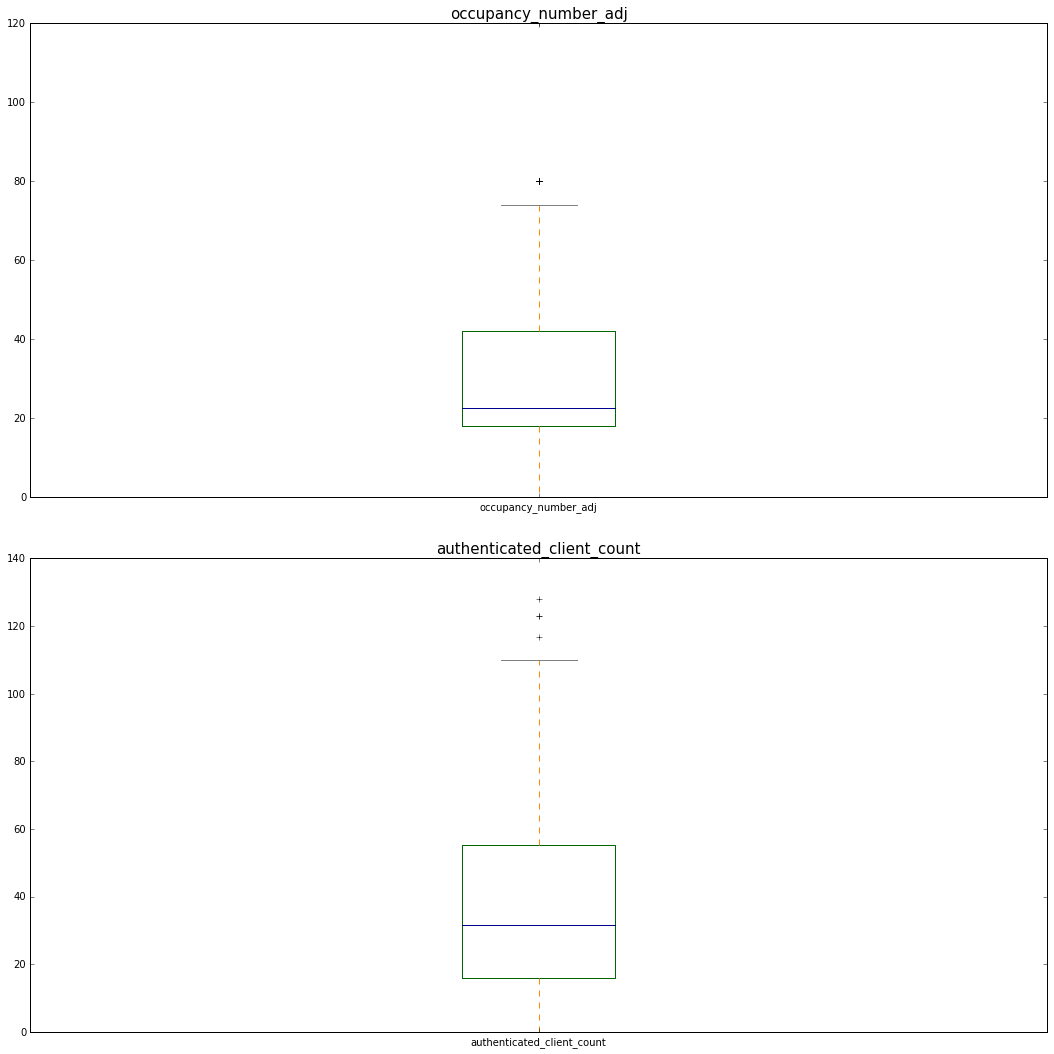

In [29]:
colour = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray') #colours for box plots

plt.figure() 

plt.subplot(211).set_title("occupancy_number_adj", fontsize=15)
df_regression["occupancy_number_adj"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.subplot(212).set_title("authenticated_client_count", fontsize=15)
df_regression["authenticated_client_count"].plot(kind = 'box', figsize = (15,15), color=colour, sym='r+') 

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0) #set padding
# plt.savefig("Box_Plots.png")

In [30]:
print(df_regression.dtypes)

corrMatrix = df_regression.corr()
corrMatrix

occupancy_number_adj          float64
authenticated_client_count    float64
dtype: object


,occupancy_number_adj,authenticated_client_count
occupancy_number_adj,1.000000,0.750301
authenticated_client_count,0.750301,1.000000


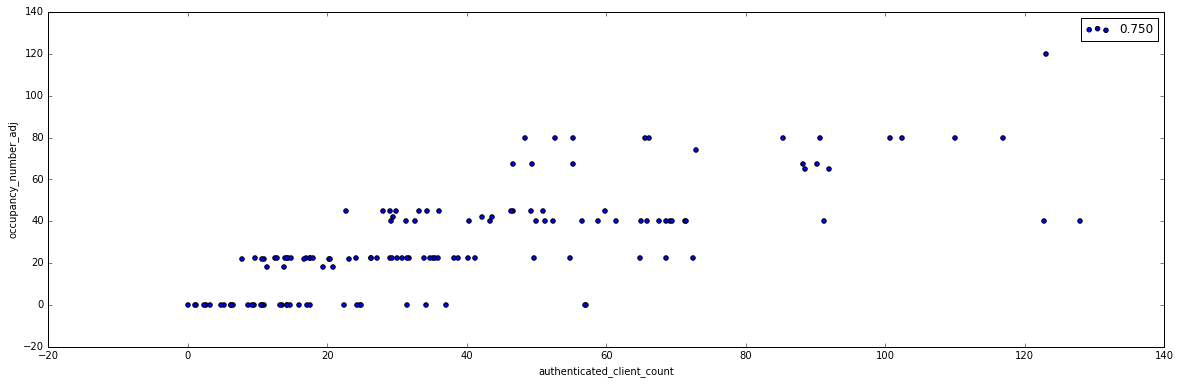

In [31]:
plt.figure() 
df_regression.plot(kind="scatter", x="authenticated_client_count", y="occupancy_number_adj", label="%.3f" % corrMatrix.as_matrix()[0,1], figsize=(20, 6))
# plt.savefig("Scatter_Plot.png")

### Regression

#### Statsmodels

In [32]:
lm_sm = sm.ols(formula="occupancy_number_adj ~ authenticated_client_count - 1", data=df_regression).fit()
print(lm_sm.summary())

                             OLS Regression Results                             
Dep. Variable:     occupancy_number_adj   R-squared:                       0.815
Model:                              OLS   Adj. R-squared:                  0.814
Method:                   Least Squares   F-statistic:                     600.9
Date:                  Wed, 27 Jul 2016   Prob (F-statistic):           9.45e-52
Time:                          12:44:57   Log-Likelihood:                -580.66
No. Observations:                   137   AIC:                             1163.
Df Residuals:                       136   BIC:                             1166.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------


#### Scikit Learn

Coefficients: 
 [ 0.72269549]
Intercept: 
 0.0
Residual sum of squares: 281.15
281.152606908
16.7676058788
Variance score: 0.55


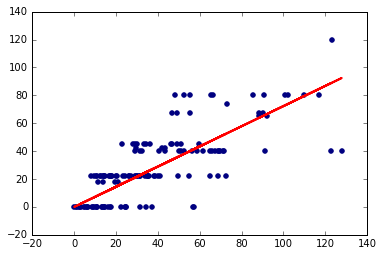

In [33]:
X = df_regression["authenticated_client_count"].reshape(len(df_regression["authenticated_client_count"]), 1)
y = df_regression["occupancy_number_adj"]

lm_scikit = LinearRegression(fit_intercept=False)

# Fit the model 
lm_scikit.fit(X, y)

# Coefficients
print("Coefficients: \n", lm_scikit.coef_)
# The intercept
print('Intercept: \n', lm_scikit.intercept_)
# The mean square error: MSE is more popular than MAE because MSE "punishes" larger errors. 
# But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.
print("Residual sum of squares: %.2f" % np.mean((lm_scikit.predict(X) - y) ** 2))
print(metrics.mean_squared_error(y, lm_scikit.predict(X)))
print(np.sqrt(metrics.mean_squared_error(y, lm_scikit.predict(X))))

# Explained variance score: coefficient of determination (R^2)
print("Variance score: %.2f" % lm_scikit.score(X, y))

# Plot outputs
plt.scatter(X, y,  color='navy')
plt.plot(X, lm_scikit.predict(X), color='red',linewidth=2)
plt.figure(figsize=(20,20))
plt.show()

In [34]:
print(lm_scikit.predict(X))

[ 20.95816921  23.96940042  17.82648875  19.63322748  15.05615604
   8.19054889  13.97211281   9.99728761  27.56567083  22.88535718
  21.6808647   22.76490793  25.4147914    9.03369362  20.95816921
  25.58342034  21.19906771  24.46840445  31.50952336  30.47365983
  21.26789585  12.64717107  10.11773686  12.28582333  10.35863536
  10.7199831    9.27459212   7.94965039  11.56312784  10.23818611
  12.64717107  52.39542302  39.6278027    7.74316596   5.66111467
  14.5984489    7.94965039  12.04492483   7.70875189  16.74244552
  14.6948083   26.01703764  16.14019928  25.89658839  29.75096434
  13.00851882  17.46514101   1.92718797  12.40627258   4.69752068
   3.7339267   22.16266169   4.45662219  36.85746999  22.71328683
  46.8547576   35.893876     6.9378767    9.75638911   7.58830264
  44.32532338  47.57745309  36.97791924  79.4965039   51.49205366
  65.88573884  49.50464106  88.89154527  48.78194557  65.47621139
  73.95583847  88.77109602  47.40882414  36.1347745   49.98643806
  37.82106

In [35]:
df_regression["predicted_occupancy"] = pd.Series(lm_scikit.predict(X), index=df_regression.index)
df_regression

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,occupancy_number_adj,authenticated_client_count,results
0,45.0,29.000000,20.958169
1,45.0,33.166667,23.969400
2,0.0,24.666667,17.826489
3,22.5,27.166667,19.633227
5,18.0,20.833333,15.056156
6,18.0,11.333333,8.190549
7,18.0,19.333333,13.972113
8,18.0,13.833333,9.997288
10,22.5,38.142857,27.565671
11,22.5,31.666667,22.885357


### Train & Testing

(95, 1)
(95,)
(42, 1)
(42,)
Coefficients: 
 [ 0.6863703]
Intercept: 
 0.0
Residual sum of squares: 359.46
359.45868464
18.9593956823
Variance score: 0.51


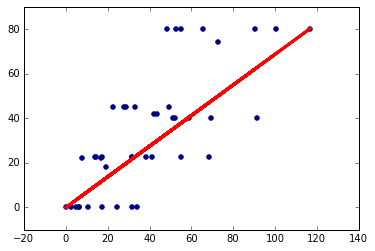

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Train the model using the training sets
lm_scikit.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', lm_scikit.coef_)
# The intercept
print('Intercept: \n', lm_scikit.intercept_)
# The mean square error
print("Residual sum of squares: %.2f" % np.mean((lm_scikit.predict(X_test) - y_test) ** 2))
print(metrics.mean_squared_error(y_test, lm_scikit.predict(X_test)))
print(np.sqrt(metrics.mean_squared_error(y_test, lm_scikit.predict(X_test))))
# Explained variance score: coefficient of determination (R^2)
print('Variance score: %.2f' % lm_scikit.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy')
plt.plot(X_test, lm_scikit.predict(X_test), color='red',linewidth=3)
plt.figure(figsize=(20,20))
plt.show()

In [37]:
# plt.scatter(lm_scikit.predict(X_train), lm_scikit.predict(X_train) - y_train, color="navy", s=40, alpha=0.5)
# plt.scatter(lm_scikit.predict(X_test), lm_scikit.predict(X_test) - y_test, color="green", s=40)
# plt.hlines(y=0, xmin=0, xmax=160)
# plt.title("Residual Plot: training (Navy) and test (Green) data")
# plt.ylabel("Residuals")

#### Construct a day column

In [38]:
# def get_day(date_int):
#     """Takes date int in format yyyymmdd and returns weekday string.
    
#     Uses datetime.date"""
    
#     weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
#     year = date_int // 10000
#     month = (date_int % 10000) // 100
#     day = date_int % 100
    
#     # return index of weekdays list, which is the correct weekday. Uses datetime.date
#     try:
#         return weekdays[date(year, month, day).weekday()]
#     except ValueError:
#         return "Incorrect number of days/months"
    
# def add_day(df):
#     """Adds Day column to df.
    
#     Uses the int date column to find the weekday it refers to."""
    
#     # copy df so it isn't overwritten
#     df_new = df.copy(deep=True)
    
#     # get day from date, add to df
#     if 'day' not in df_new.columns:
#         days = []
#         for i in range(len(df_new)):
#             days.append(get_day(df_new.date.iloc[i]))
#         df_new["day"] = days
#     else:
#         for i in range(len(df_new)):
#             if pd.isnull(df_new.day.iloc[i]):
#                 df_new["day"].iloc[i] = get_day(df_new.date.iloc[i])
#     return df_new